## Table of Contents

**1.Introduction<br>**
  1.1 Data Cleaning<br>
**2.Data Exploration<br>**
2.1 General Relationship<br>
2.2 General Distribution<br>
2.3 Genre<br>
2.4 Production Company<br>
2.5 Country<br>
2.6 Visualize the Relationship between mean_vote and Others<br>
**3.Classification Algorithm Building**<br>
3.1 Logistic Regression<br>
3.2 Ridge Regression<br>
3.3 SVC Classifier<br>
3.4 Binary Classifier/SGD classification<br>
3.5 KNN Classifier<br>
3.6 Decision Tree<br>
3.7 Bagging<br>
3.8 Ada Boosting Classifier<br>
3.9 Gradient Boosting Classifier<br>
3.10 Random Forest<br>
**4. Voting**<br>
4.1 Hard Voting<br>
4.2 Soft Voting<br>
**5. End Notes**<br>
5.1 Shortcomings<br>
5.2 Data Source<br>

## 1.Introduction

The phrase 'watch a movie' has always been related with enjoyment, with pleasure. However, watching a movie is not always a delightful thing. Sometimes a bad movie is going to ruin your mood for the day. But how can you distinguish a good movie/a bad movie before hand? What signs might indicate that it might not be a good movie that is worth watching?

To deal with this problem, we could look into the historical rating about the movies. We found two dataset that includes the IMBD-movie-rating-related information. We could look deeper into these datasets and try to find some insight from it.

### 1.1 Data Cleaning

First of all, we need to do some basic data cleaning.

In [57]:
#general importing of the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#merge the two datasets based on the movie id
movies = pd.read_csv('/Users/yvonne/Downloads/IMDb movies.csv')
ratings = pd.read_csv('/Users/yvonne/Downloads/IMDb ratings.csv')
final = pd.merge(left=ratings, right=movies, left_on='imdb_title_id', right_on='imdb_title_id')

/Users/yvonne/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


After merging these two datasets, we now have a huge dataset. To make the cleaning process easier, we will select only the columns we need.

In [3]:
#selecting the columns we are interested in
movie =  final[['total_votes', 'mean_vote', 'year','genre','duration','country','language',
                'production_company','budget','worlwide_gross_income']].copy()
#renaming the column
movie = movie.rename(columns={'worlwide_gross_income':'gross'})

In [4]:
#drop the columns with missing values
movie = movie.dropna()
#modify the format of some columns
#keep the first genre as the main genre of the movie
movie['genre'] = movie.genre.str.split(',').str.get(0)
movie['language'] = movie.language.str.split(',').str.get(0)
movie['country'] = movie.country.str.split(',').str.get(0)
movie = movie[movie['language'] != 'None']
#delete the records with non-dollar gross/budgets
movie = movie.loc[movie['budget'].str.startswith('$')]
movie['budget'] = movie['budget'].str.replace('$','')
movie['gross'] = movie['gross'].str.replace('$','')

In [5]:
#change the type of some columns
movie['budget'] = movie['budget'].astype(int)
movie['gross'] = movie['gross'].astype(int)

The column **country** and **production company** are also interesting to us, but to make them easier for the classifier to process, we need to change the type of these two column. 

In [6]:
df1 = pd.DataFrame(movie['country'].value_counts())
movie = pd.merge(left=movie, right=df1, left_on = 'country', right_on = df1.index)

In [7]:
df2 = pd.DataFrame(movie['production_company'].value_counts())
movie = pd.merge(left=movie, right=df2, left_on = 'production_company', right_on = df2.index)

Now we have a dataframe with all the columns cleaned. 


## 2. Data Exploration

### 2.1 General Relationships

Our target is **mean_vote**. To have a basic idea of what are the relationship between mean_vote and other variables, we can plot a heatmap with all the numerical variables in the dataframe.

Text(0.5, 0.98, 'correlation')

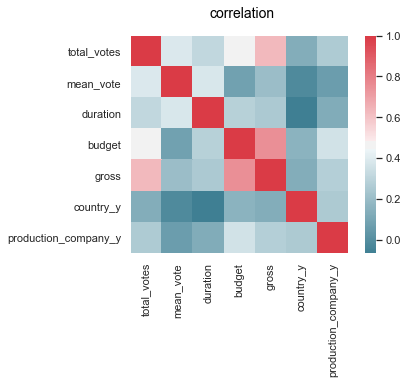

In [83]:
f, ax = plt.subplots(figsize=(6, 4))
corr = movie.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.set(font_scale=1)
f.suptitle('correlation', fontsize=14, color='black')

From the above heatmap, we can't see any significant relationship between **mean_vote** and other variables. But we spot rather strong correlations between **gross** and **budget**, **total_votes**. This makes sense as movies with higher budget would typically spend more on marketing. This will attract more audience, which then leads to higher gross and more votes.

### 2.2 General Distribution

To see the distribution of these variables, we can plot them into distribution plots

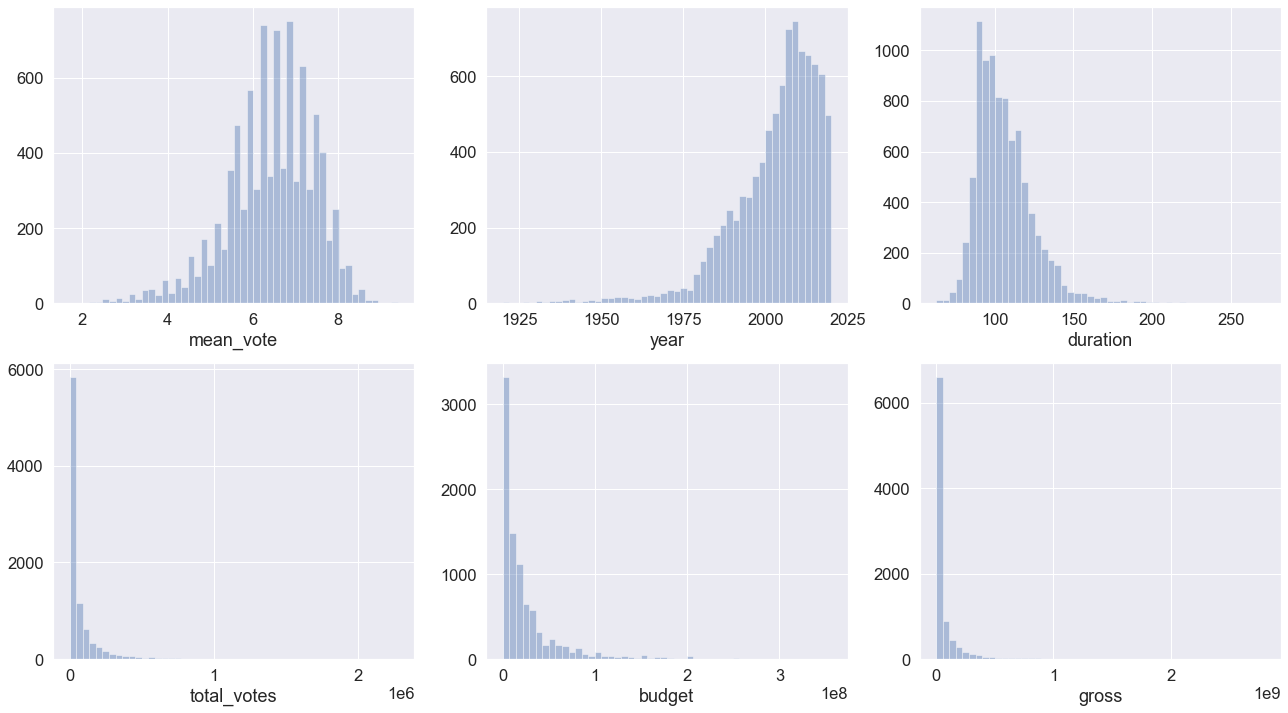

In [74]:
fig, ax =plt.subplots(2,3,figsize=(22,12))
sns.set(font_scale = 2) 
one = sns.distplot(movie['mean_vote'].sort_values(), kde = False, ax = ax[0,0])
two = sns.distplot(movie['year'], kde = False, ax=ax[0,1])
three = sns.distplot(movie['duration'], kde = False, ax=ax[0,2])
four = sns.distplot(movie['total_votes'], kde = False, ax=ax[1,0])
five = sns.distplot(movie['budget'], kde = False, ax=ax[1,1])
six = sns.distplot(movie['gross'], kde = False, ax=ax[1,2])

From the distribution charts above, we can get the following conclusions:<br>
For **mean_vote**, the scores of the films are mainly between 5.5 and 8. <br>
For **year**, the number of movies per year has generally been increasing since 1960, reached its peak at around 2010, then started to decline.<br>
For **duration**, the majority of the films have a duration between 70 minutes and two hour.<br>
For **budget**, it is a lot like 
The distribution of **budget**, **total_vote** and **gross** are pretty similar. Most of the films have low budget, low gross and a small number of votes. This is reasonable as there could only be a few blockbusters each year. Movie with a higher budget tends to spend more on marketing. This will attract more audiences, which then leads to higher gross and larger number of votes.

### 2.3 Genre

Then we can shift our attention to the genre of the movies. Which generes are more attractive/seem more profitable to the producers?

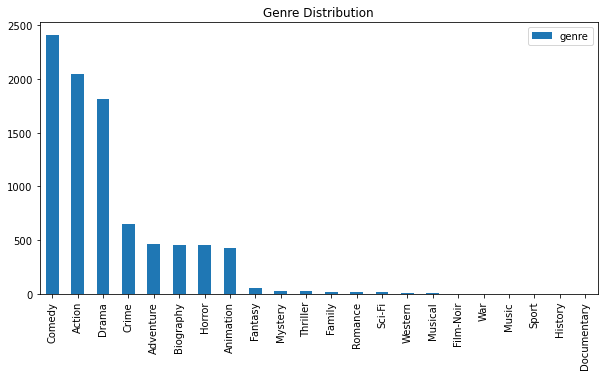

In [10]:
df_genre = pd.DataFrame(movie['genre'].value_counts())
df_genre.plot(kind = 'bar',figsize = (10,5),title = 'Genre Distribution')

Comedy, Action and Drama are three major catagories of movies that are produced each year. The number of movies that are placed in these catagories almost doubled the fourth and the following catagories. But are these producers making the right choice? Are these catagories really more popular among audiences? We can aggregate the dataset to find out the result.

In [11]:
cata = pd.DataFrame(movie.groupby('genre',as_index=False)['mean_vote'].mean())
cata = pd.merge(left=cata, right=df_genre, left_on='genre', right_on=df_genre.index)
cata = cata.drop(columns=['genre_x'])
cata.sort_values(by='mean_vote')

,genre,mean_vote,genre_y
18,Sport,4.350000,2
17,Sci-Fi,5.460000,15
12,Horror,5.668571,455
9,Fantasy,6.049091,55
19,Thriller,6.213793,29
0,Action,6.237286,2049
4,Comedy,6.275727,2406
8,Family,6.311765,17
11,History,6.400000,2
16,Romance,6.460000,15


From the result, we can see that the top3 catagories: Comedy, Action and Drama on average are rated 6.28, 6.24 and 6.71 respectively. Considering this, choosing to produce/watch a drama movie could be a safer bet. With such a large volume, a score of 6.71 is pretty remarkable.

On the other hand, all the highly scored genres have small volumes. It could indicate that when a producer decides to produce a movie that belongs to a not-so-popular genre, he might have a pretty good script. Looking for good movies from these minor catagories could also be a good choice.

### 2.4 Production Company

Now let's look at the production company.<br>
We are mainly interested in the relationship between the size of the company and the quality of the company. We all know some major production companies, such as 21Century Fox, Walter Disney and Warner Bros. To some extent, their title seems to be the guarantee of their lowest quality. But are they really trustworthy? 

In [12]:
company = pd.DataFrame(movie.groupby('production_company',as_index=False)['mean_vote'].mean())
df_company = pd.DataFrame(movie['production_company'].value_counts())
company = pd.merge(left=company, right=df_company, left_on='production_company', right_on=df_company.index)
company = company.drop(columns=['production_company_x'])
company = company.rename(columns={'production_company_y':'count'})

In [13]:
for i in range(0,3686):
    if company['count'].iloc[i] <= 15:
        company['count'].iloc[i] = 'small'
    elif company['count'].iloc[i] <= 70:
        company['count'].iloc[i] = 'median small'
    elif company['count'].iloc[i] <= 130:
        company['count'].iloc[i] = 'median large'
    else:
        company['count'].iloc[i] = 'large'

/Users/yvonne/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
company2 = pd.DataFrame(company.groupby('count',as_index=False)['mean_vote'].mean())
company2.sort_values(by='mean_vote')

,count,mean_vote
3,small,6.330143
2,median small,6.472568
0,large,6.509316
1,median large,6.648778


We can see that the average score and the size of the company are indeed positively correlated. This could suggest larger companies are indicator of higher quality. But there could also be another possibility: some fans of these companies are going to give high score to the films no matter what the movie is actually like. To some extent, having a large audience base could push the company to a benign circle.

### 2.5 Country

Similar to production companies, some countries are in a more dominated position in the film industry, while others are not. We can do a simple analysis to see the relationship between the country's market size in the movie industry and movie quality.

In [15]:
country = pd.DataFrame(movie.groupby('country',as_index=False)['mean_vote'].mean())
df_country = pd.DataFrame(movie['country'].value_counts())
country = pd.merge(left=country, right=df_country, left_on='country', right_on=df_country.index)
country = country.drop(columns=['country_x'])
country = country.rename(columns={'country_y':'count'})

In [16]:
for i in range(0,87):
    if country['count'].iloc[i] <= 15:
        country['count'].iloc[i] = 'small'
    elif country['count'].iloc[i] <= 70:
        country['count'].iloc[i] = 'median small'
    elif country['count'].iloc[i] <= 150:
        country['count'].iloc[i] = 'median large'
    else:
        country['count'].iloc[i] = 'large'

/Users/yvonne/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
country2 = pd.DataFrame(country.groupby('count',as_index=False)['mean_vote'].mean())
country2.sort_values(by='mean_vote')

,count,mean_vote
0,large,6.311157
1,median large,6.435019
2,median small,6.436369
3,small,6.713281


The result is quite suprising. Larger countries tends to produce movie of lower quality, while smaller countries' average movie quality is higher. A country's position in the movie industry cannot be a guarantee of the quality.

### 2.6 Visualize the Relationship between mean_vote and Others

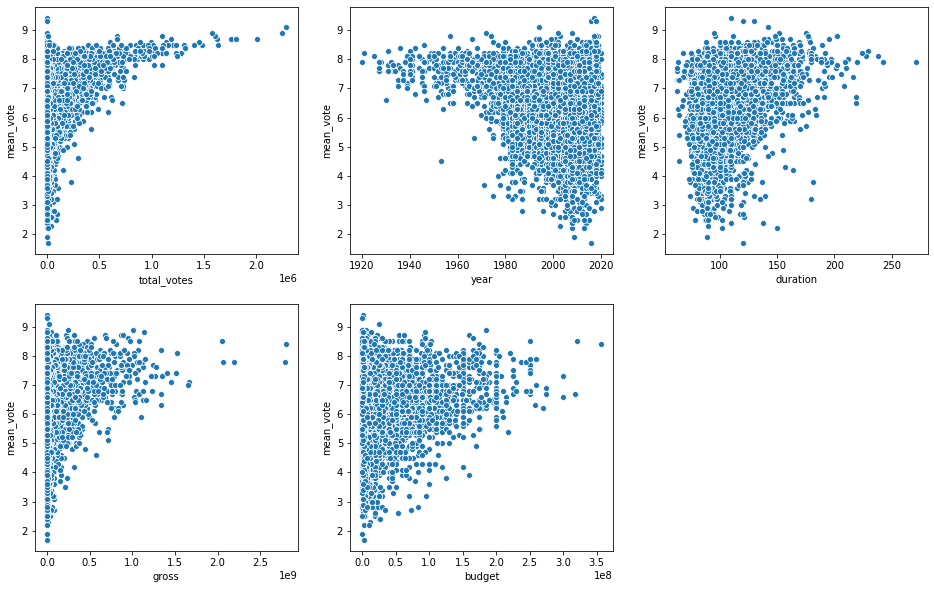

In [18]:
fig, ax = plt.subplots(2,3, figsize=(16,10))

sns.scatterplot(x='total_votes', y='mean_vote', data=movie, ax=ax[0,0])

sns.scatterplot(x='year', y='mean_vote', data=movie, ax=ax[0,1])

sns.scatterplot(x='duration', y='mean_vote', data=movie, ax=ax[0,2])

sns.scatterplot(x='gross', y='mean_vote', data=movie, ax=ax[1,0])

sns.scatterplot(x='budget', y='mean_vote', data=movie, ax=ax[1,1])

fig.delaxes(ax[1,2])

From the above scatter plots, we can draw the following conclusions:
1. The number of votes is positively correlated with the quality of the film.
2. Older films often have higher scores. This could be due to the general nostalgia of modern people.
3. Longer movie tends to have higher score.
4. Movie with a low gross doesn't necessarily have a low score, but movie with a higher gross tends to have a higher score.
5. Similar to gross, there are certain highly scored movies made with low budgets. But generally, a higher budget indicates a higher score.

## 3. Classification Algorithm Building

Now we have a basic understanding of the dataset we have. But we still don't know how to choose safely among all the movies. To make it easier, we can build an algorithm to distinguish between the good ones and the poor ones. Once we have such an algorithm, we could input some attibutes of the film and it's going to tell us whether it's worth a try or not.

In [19]:
#create a new dataset and make some modifications
trees = movie[['total_votes','year','duration','budget','gross','mean_vote','country_y','production_company_y']].copy()
trees['year'] = trees['year'].astype(int)

In [20]:
#seperate the good ones and poor ones based on their overall score
for i in range(0,8922):
    if trees['mean_vote'].iloc[i] >= 6.5:
        trees['mean_vote'].iloc[i] = 'good'
    else:
        trees['mean_vote'].iloc[i] = 'poor'

/Users/yvonne/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
#select the attributes and the target
X = trees[['total_votes','year','duration','budget','gross','country_y','production_company_y']] 
y = trees['mean_vote']

In [22]:
#split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

After cleaning the dataset and splitting the data, we can now try all the possible classification algorithms. To make better selection between them, in this step, we will start to tune them.

### 3.1 Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

LogisticRegression()

In [24]:
y_pred_log = log_clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_log)*100)
print ("Report : ",  classification_report(y_test, y_pred_log))

Accuracy :  66.4985994397759
Report :                precision    recall  f1-score   support

        good       0.69      0.66      0.67       934
        poor       0.64      0.67      0.66       851

    accuracy                           0.66      1785
   macro avg       0.67      0.67      0.66      1785
weighted avg       0.67      0.66      0.67      1785



### 3.2 Ridge Regression

In [25]:
from sklearn.linear_model import RidgeClassifier
rid_clf = RidgeClassifier()
rid_clf.fit(X_train,y_train)
y_pred_rid = rid_clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_rid)*100)
print ("Report : ",  classification_report(y_test, y_pred_rid))

Accuracy :  68.68347338935574
Report :                precision    recall  f1-score   support

        good       0.74      0.63      0.68       934
        poor       0.65      0.75      0.70       851

    accuracy                           0.69      1785
   macro avg       0.69      0.69      0.69      1785
weighted avg       0.69      0.69      0.69      1785



### 3.3 SVC Classifier

In [138]:
from sklearn.svm import SVC
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.585119 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.527298 (0.002667) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.585119 (0.016148) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.505912 (0.017624) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.527252 (0.002606) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.584511 (0.015631) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.506099 (0.017820) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.526645 (0.001864) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.579937 (0.015567) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.505678 (0.017651) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.527112 (0.000552) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.568636 (0.017041) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.506890 (0.020131) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.527112 (0.000552) with: {'C': 0.01, 'gamma': 'scale', 

In [214]:
svc_clf = SVC(C=50, kernel = 'rbf', gamma='scale')
svc_clf.fit(X_train, y_train)

SVC(C=50)

In [215]:
y_pred_svc = svc_clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_svc)*100)
print ("Report : ",  classification_report(y_test, y_pred_svc))

Accuracy :  56.80672268907563
Report :                precision    recall  f1-score   support

        good       0.61      0.48      0.54       934
        poor       0.54      0.66      0.59       851

    accuracy                           0.57      1785
   macro avg       0.57      0.57      0.57      1785
weighted avg       0.58      0.57      0.57      1785



### 3.4 Binary Classifier/SGD classification

In [216]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(random_state=42)

In [217]:
y_pred_sgd = sgd_clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_sgd)*100)
print ("Report : ",  classification_report(y_test, y_pred_sgd))

Accuracy :  57.25490196078431
Report :                precision    recall  f1-score   support

        good       0.63      0.45      0.53       934
        poor       0.54      0.70      0.61       851

    accuracy                           0.57      1785
   macro avg       0.58      0.58      0.57      1785
weighted avg       0.59      0.57      0.57      1785



### 3.5 KNN Classifier

In [70]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.585352 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
0.554524 (0.019288) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.554524 (0.019288) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.553497 (0.019267) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.554899 (0.021306) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.561626 (0.019118) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.562466 (0.017704) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.565969 (0.017148) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.565128 (0.017922) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.570405 (0.015030) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.564708 (0.018191) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.575309 

In [218]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=17, metric='manhattan',  weights= 'uniform')
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
print ("Accuracy : ", accuracy_score(y_test,y_pred_knn)*100)
print ("Report : ",  classification_report(y_test, y_pred_knn))

Accuracy :  58.0952380952381
Report :                precision    recall  f1-score   support

        good       0.60      0.60      0.60       934
        poor       0.56      0.56      0.56       851

    accuracy                           0.58      1785
   macro avg       0.58      0.58      0.58      1785
weighted avg       0.58      0.58      0.58      1785



### 3.6 Decision Trees

As the performance of a single decision tree will be poorer than random forest, we are not going to tune the decision trees now.

#### 3.6.1 Using Gini

In [225]:
clf_gini = DecisionTreeClassifier(criterion = 'gini',
                                 max_depth = 3,
                                 min_samples_leaf=100,
                                 random_state = 42)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100, random_state=42)

In [226]:
y_pred_gini = clf_gini.predict(X_test)

#### 3.6.2 Using Entropy

In [227]:
clf_entropy = DecisionTreeClassifier(criterion = 'entropy',
                                 max_depth = 3,
                                 min_samples_leaf=50,
                                 random_state = 42)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=50,
                       random_state=42)

In [228]:
y_pred_entro = clf_entropy.predict(X_test)

#### 3.6.3 Evaluating these models

In [229]:
# Evaulating predictions with test labels
                  # For evaluating the model
gini_tree_score = accuracy_score(y_test,y_pred_gini)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_gini)*100)         # Evaulating predictions with test labels
print ("Report : ",  classification_report(y_test, y_pred_gini))

Accuracy :  66.55462184873949
Report :                precision    recall  f1-score   support

        good       0.67      0.70      0.69       934
        poor       0.65      0.63      0.64       851

    accuracy                           0.67      1785
   macro avg       0.66      0.66      0.66      1785
weighted avg       0.67      0.67      0.67      1785



In [230]:
y_pred_entropy = clf_entropy.predict(X_test)
entro_tree_score = accuracy_score(y_test,y_pred_entropy)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_entropy)*100)
print ("Report : ",  classification_report(y_test, y_pred_entropy))

Accuracy :  68.4593837535014
Report :                precision    recall  f1-score   support

        good       0.69      0.72      0.70       934
        poor       0.68      0.65      0.66       851

    accuracy                           0.68      1785
   macro avg       0.68      0.68      0.68      1785
weighted avg       0.68      0.68      0.68      1785



### 3.7 bagging

In [100]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
grid = {
        "n_estimators" :[10, 100, 500, 1000],
        }
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.742419 using {'n_estimators': 1000}
0.719955 (0.018423) with: {'n_estimators': 10}
0.738962 (0.016478) with: {'n_estimators': 100}
0.742419 (0.015961) with: {'n_estimators': 1000}


In [231]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=1000,
        bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1)

In [233]:
y_pred_bag = bag_clf.predict(X_test)

In [234]:
bag_score = accuracy_score(y_test,y_pred_bag)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_bag)*100)
print ("Report : ",  classification_report(y_test, y_pred_bag))

Accuracy :  74.6218487394958
Report :                precision    recall  f1-score   support

        good       0.78      0.72      0.75       934
        poor       0.72      0.78      0.74       851

    accuracy                           0.75      1785
   macro avg       0.75      0.75      0.75      1785
weighted avg       0.75      0.75      0.75      1785



#### 3.7.1 Out-Of-Bag evaluation

In [239]:
oobag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=1000,
        bootstrap=True, n_jobs=-1, oob_score=True)
oobag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, oob_score=True)

In [240]:
oobag_clf.oob_score_

0.7405072159170519

In [241]:
y_pred_oob = oobag_clf.predict(X_test)
oob_score = accuracy_score(y_test,y_pred_oob)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_oob)*100)
print ("Report : ",  classification_report(y_test, y_pred_oob))

Accuracy :  74.90196078431373
Report :                precision    recall  f1-score   support

        good       0.78      0.72      0.75       934
        poor       0.72      0.78      0.75       851

    accuracy                           0.75      1785
   macro avg       0.75      0.75      0.75      1785
weighted avg       0.75      0.75      0.75      1785



### 3.8 Ada Boosting Classifier

In [40]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42, max_depth=2),
    random_state = 42)

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[10, 100, 200, 250],
              "learning_rate":  [0.05, 0.5, 1.5, 2.5]}

grid_ada_clf = GridSearchCV(ada_clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy", n_jobs= -1, verbose = 1)
grid_ada_clf.fit(X_train, y_train)
grid_ada_clf.best_params_

ada_pred = grid_ada_clf.predict(X_test)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.4min finished


In [41]:
print ("Accuracy : ", accuracy_score(y_test,ada_pred)*100)
print ("Report : ",  classification_report(y_test, ada_pred))

Accuracy :  73.44537815126051
Report :                precision    recall  f1-score   support

        good       0.78      0.69      0.73       934
        poor       0.70      0.78      0.74       851

    accuracy                           0.73      1785
   macro avg       0.74      0.74      0.73      1785
weighted avg       0.74      0.73      0.73      1785



### 3.9 Gradient Boosting Classifier

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
gb_clf = GradientBoostingClassifier(random_state=42)

param_grid = {
              'n_estimators' : [25, 50 ,75, 100, 200],
              'learning_rate': [0.005 ,0.05, 0.5, 1.5],
              'max_depth': [2, 4, 6, 8],
              'max_features': [2, 3, 4, 5, 6] 
              }
grid_gb_clf = GridSearchCV(gb_clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy", n_jobs= -1, verbose = 1)
grid_gb_clf.fit(X_train, y_train)

gb_pred = grid_gb_clf.predict(X_test)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.1min finished


In [37]:
print ("Accuracy : ", accuracy_score(y_test,gb_pred)*100)
print ("Report : ",  classification_report(y_test, gb_pred))

Accuracy :  73.78151260504202
Report :                precision    recall  f1-score   support

        good       0.78      0.69      0.73       934
        poor       0.70      0.78      0.74       851

    accuracy                           0.74      1785
   macro avg       0.74      0.74      0.74      1785
weighted avg       0.74      0.74      0.74      1785



### 3.10 Random Forest

In [27]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 10, 20],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [30]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [33]:
rnd_clf = RandomForestClassifier(bootstrap = True,
                                        max_depth= None,
                                         max_features= 'sqrt',
                                         min_samples_leaf= 1,
                                         min_samples_split= 10,
                                         n_estimators= 1600)


In [34]:
rnd_clf.fit(X_train, y_train)
y_pred_rf_bt = rnd_clf.predict(X_test)
better_rf_score = accuracy_score(y_test,y_pred_rf_bt)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_rf_bt)*100)

print ("Report : ",  classification_report(y_test, y_pred_rf_bt))

Accuracy :  75.23809523809524
Report :                precision    recall  f1-score   support

        good       0.79      0.72      0.75       934
        poor       0.72      0.79      0.75       851

    accuracy                           0.75      1785
   macro avg       0.75      0.75      0.75      1785
weighted avg       0.76      0.75      0.75      1785



From the above experiments, we can see that the best models are random forest(75.24), oob bagging(74.90), Gradient Boosting(73.78) and Ada boosting(73.45). We can ensemble them to reach a better solution.

## 4. Voting

In [42]:
estimator = [] 
estimator.append(('RF',RandomForestClassifier(bootstrap = True,
                                              max_depth= None,
                                              max_features= 'sqrt',
                                              min_samples_leaf= 1,
                                              min_samples_split= 10,
                                              n_estimators= 1600))) 
estimator.append(('OOB', BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000,
                                           bootstrap=True, n_jobs=-1, oob_score=True))) 
estimator.append(('GB', grid_gb_clf)) 
estimator.append(('ADAB', grid_ada_clf)) 

### 4.1 Hard Voting

In [46]:
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') 
hard_voting.fit(X_train, y_train) 
y_pred_hv = hard_voting.predict(X_test) 

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.9min finished


Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.4min finished


In [47]:
hv_score = accuracy_score(y_test,y_pred_hv)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_hv)*100)
print ("Report : ",  classification_report(y_test, y_pred_hv))

Accuracy :  74.34173669467788
Report :                precision    recall  f1-score   support

        good       0.77      0.73      0.75       934
        poor       0.72      0.76      0.74       851

    accuracy                           0.74      1785
   macro avg       0.74      0.74      0.74      1785
weighted avg       0.74      0.74      0.74      1785



### 4.2 Soft Voting

In [48]:
soft_voting = VotingClassifier(estimators = estimator, voting ='soft') 
soft_voting.fit(X_train, y_train) 
y_pred_sv = soft_voting.predict(X_test) 

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.9min finished


Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.3min finished


In [49]:
sv_score = accuracy_score(y_test,y_pred_sv)*100
print ("Accuracy : ", accuracy_score(y_test,y_pred_sv)*100)
print ("Report : ",  classification_report(y_test, y_pred_sv))

Accuracy :  75.12605042016807
Report :                precision    recall  f1-score   support

        good       0.79      0.71      0.75       934
        poor       0.72      0.79      0.75       851

    accuracy                           0.75      1785
   macro avg       0.75      0.75      0.75      1785
weighted avg       0.75      0.75      0.75      1785



After ensembling the best few algorithms we choose, we can see soft voting performs slightly better than hard voting. It can correctly predict the class of the movie 75% percent of the time. With this soft voting algorithm, we can be more confident that the movie we choose would be more enjoyable. 

### 5. End Notes

#### 5.1 Shortcomings

1. Due to the limited time and effort, this study is only looking at the average score of the movie. In the original datasets, there are more details about the ratings. Including the rating by different demographic groups. Given more time, we could look at the rating from different demographic groups. Using these information, we could make this movie-selection system more personalized for different user groups. In the original datasets, the information of the crew is also provided, including these information could make our classification algorithm more accurate.
2. For convenience, in this study, we manually divided the movies into only two catagories: Good and Poor. To provide better service, we could also divide them into more catagories. 

#### 5.2 Data Source

The dataset is found through https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+ratings.csv

**Movie Dataset**:<br>
total_votes: Total votes received by this film.<br>
mean_vote: Total mean votes of the film.<br>
year: The year the film was produced.<br>
genre: The genre of the film.<br>
duration: The duration of the film.<br>
country: The country the film was produced in.<br>
language: The main language spoken in this film.<br>
production_company: The production company of the film.<br>
budget: The budget of the film.<br>
worlwide_gross_income: The worldwide gross of the film.<br>

In [53]:
#Importing wordcount module
import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count
#Run to get notebook wordcount (includes Appendix)
nb_path = "./Individual_Coursework_20102546.ipynb"
word_count = nb_word_count(nb_path)
print(word_count)

1336
